# Introduction
The aim of this assignment was to develop a deeper understanding of KNN classifier models, and in particular test the impact of using dynamic time warping (DTW) as a measure of distance between elements. In KNN models, to assess the k training examples that are most similar to the input examples a measure of distance is required, which can become complicated when simple measures such as ordinal difference or euclidean are not appropriate for the dataset. DTW is an example of such a distance function, and is appropriate for cases where input sizes are not the same, allowing us to match one positional element in the first array with the most similar element in the second, even if it is not in the same position. While the dataset used in these examples have the same length, this feature is still quite useful as the same trends are observed in each of the 3 categories but at slightly varying times. Therefore a simple 1:1 matching may not result in the best classification prediction. DTW also contains the concept of a 'window', which is introduced to limit the number of matches each element can have to the value of 1 + the window size (i.e. setting to 0 will mean each element will be mapped to its corresponding positional element. In addition, the window cannot be less than the difference in lengths of both arrays to ensure sufficient matching.

The solution is broken into 2 tasks:

<b>Task 1</b><br>
In this task I have designed a simple 1NN classifer using the DTW distance metric provided, assessing it's performance on a sample dataset and comparing it to the default euclidean distance metric in the KNeighborsClassifier method from the scikit-learn package. I also explore varying the value of the window parameter to assess the impact of classification accuracy for this particular dataset.

<b>Task 2</b><br>
In the second task I conduct additional exploration on the DTW distance and its effect on classification for the provided dataset. The DTW method signature is amended to work as a customised distance metric for an sklearn classifier. Following this, the optimal window size found in task 1 is used to compare the performance of KNN Euclidean vs KNN DTW, this time using only the sklearn KNN implementation, but varying the distance metric provided. 

### Importing required packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import sys
import unittest
#!pip install prettytable
from prettytable import PrettyTable

## Task 1

### 1.1 Creating a 1-NN classifier

In [2]:
def dtw(s, t, window):
    """function that returns the minimum distance between 2 lists using a dtw measure, using the 
    window variable to dictate the number of matches a single value can have."""
    n, m = len(s), len(t)
    w = np.max([window, abs(n-m)]) # warping cannot be less than the difference in lengths. 
    dtw_matrix = np.zeros((n+1, m+1))
    
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            dtw_matrix[i, j] = 0
    
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix[-1,-1]

def predict(training, testing_row, training_y, **kwargs):
    """function that is used by the below assess method. It takes a single row to be classified, loops through all
    of the training rows, passing each alongside the testing_row to the above dtw method to see which pair have the
    minimum distance between them. The training row with the minimum distance is most similar to the input, and
    therefore its corresponding y-value is returned as the prediction."""
    
    # set window to value passed if there was one, otherwise 0
    if "window" in kwargs:
        window=kwargs["window"]
    else:
        window = 0
    # initialise index
    index = 0
    # initialise minimum number to largest possible so that true minimum can be set
    minimum = sys.maxsize
    # loop through training rows to see which is the most similar according to the dtw method, assign index variable
    # to index of minimum row
    for i in range(len(training)):
        dtw_output = dtw(training[i], testing_row, window=window)
        # sense check to see if there were ties to compare against euclidean differences
        if dtw_output == minimum:
            print("Tie")
        if dtw_output < minimum:
            minimum = dtw_output
            index = i
    # return the classification
    return training_y[index]

def assess(train, test, train_y, test_y, **kwargs):
    """function that passes each row in a test list to the above function to get the predicted classification and
    then compares it to the actual. Keeps a track of the number of correct predictions and returns this figure."""
    
    # initialise
    correct = 0
    # loop through test rows, passing them to predict method
    for i in range(len(test)):
        # pass optional window paramater only if one was passed to this method
        if "window" in kwargs:
            prediction = predict(train, test[i], train_y, window=kwargs["window"])
        else:
            prediction = predict(train, test[i], train_y)
        # if prediction was correct increment by 1
        if prediction == test_y[i]:
            correct += 1
    return correct

<b>Unit Testing for the 1-NN classifier</b>

Below I have created some simple test methods to ensure that the methods I created above are functioning as expected. The first test case checks the predict method, which should return a classification prediction for a test array based on a training 2D array, while the second checks if a test 2D array has the number of correct predictions returned as expected. 

In [3]:
class TestMethods(unittest.TestCase):
    
    def __init__(self, *args, **kwargs):
        super(TestMethods, self).__init__(*args, **kwargs)
        self.test_arr1 = [[2, 2, 2, 2, 2, 2], [3, 3, 3, 3, 3, 3], [4, 4, 4, 4, 4, 4]]
        self.test_arr2 = [2, 2, 2, 2, 2, 2]
        self.test_arr3 = [[2, 2, 2, 2, 2, 2], [3, 3, 3, 3, 3, 3]]
        self.test_arr4 = ["Twos", "Threes", "Fours"]
        
    def test_predict(self):
        prediction = predict(self.test_arr1, self.test_arr2, self.test_arr4)
        self.assertEqual(prediction, "Twos")
        
    def test_assess(self):
        correct = assess(self.test_arr1, self.test_arr3, self.test_arr4, ["Twos", "Threes"])
        self.assertEqual(correct, 2)

if __name__ == '__main__':
    unittest.main(argv=['ignore'], exit=False)

..
----------------------------------------------------------------------
Ran 2 tests in 0.004s

OK


### 1.2 Testing the classifier on UMD_TEST.txt

Below I test how accurately the above classifier can be used to make predictions on the UMD_TEST text file. First I explore this file a bit to get a sense of what I am dealing with.

In [4]:
# read in the dataset, setting delimter as 2 blank spaces
umd = pd.read_csv('UMD_TEST.txt', delimiter = '  ', header=None)

<ipython-input-4-b9eaa1d05fbe>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  umd = pd.read_csv('UMD_TEST.txt', delimiter = '  ', header=None)


In [5]:
umd

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
0,1.0,0.017644,0.030949,0.050555,0.044484,0.053277,0.041576,0.030947,0.027086,0.013764,...,0.024575,0.033780,0.026589,0.013932,0.024928,0.022589,0.038248,0.049838,0.053419,0.040420
1,1.0,0.041296,0.003551,0.027470,0.013158,0.009571,0.008074,0.043743,0.040592,0.012190,...,0.060539,0.046991,0.023586,0.001562,-0.002196,0.036730,0.039027,0.007754,0.004697,0.031440
2,1.0,-0.000720,0.013283,0.029450,0.045201,0.006317,0.018805,0.028901,0.013832,0.015240,...,0.016442,0.039508,0.015171,0.034708,0.010835,0.002942,0.006924,0.029502,0.040786,0.023144
3,1.0,0.005201,0.013363,0.025733,0.026653,0.038946,0.012494,0.028303,0.032011,0.009467,...,0.006383,0.037448,0.044335,0.011143,-0.003624,0.001467,0.020991,0.027675,0.001621,0.015858
4,1.0,0.022926,0.027036,0.011668,0.019500,0.036049,-0.001297,0.019717,0.039583,0.020628,...,0.026997,0.036653,0.018117,0.018314,0.012536,0.040599,0.016590,0.032730,0.002498,0.011260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,3.0,0.008298,0.017240,0.010756,0.049488,0.005331,0.036829,0.045530,0.046181,0.044288,...,0.015062,0.028319,0.028443,0.051677,0.036134,0.038030,0.047388,0.006875,0.052691,0.051594
140,3.0,0.004801,0.042964,0.034519,-0.003426,-0.003353,0.005231,0.002309,0.029905,0.011177,...,0.017705,0.045264,0.041434,0.040670,0.034613,0.001551,0.017716,0.001042,0.047787,0.020318
141,3.0,0.033658,0.038235,0.009848,0.016061,0.026287,0.029979,0.024099,0.023647,0.017566,...,0.019306,0.022595,0.014942,0.009259,0.019186,0.035905,0.031095,0.006592,0.017948,-0.003614
142,3.0,0.022805,0.020270,0.015546,0.038309,0.016303,0.011456,0.018286,0.015730,0.007319,...,0.013016,0.030138,0.025736,0.005955,0.050157,0.014435,0.005638,0.036126,0.010751,-0.005682


In [6]:
umd[0].unique().tolist()

[1.0, 2.0, 3.0]

Dealing with a dataset of 144 rows and 151 columns. The first column is the classification (1, 2 or 3) of the row, with each row representing a time series.

Therefore I will pop the first column as the y values and keep the remainder as the x values (i.e. the y values are the dependent variables and x values are the independent variables).

In [7]:
y_vals = umd.pop(0).values
X_vals = umd.values

In [8]:
X_vals

array([[ 0.01764446,  0.03094927,  0.05055511, ...,  0.04983778,
         0.05341944,  0.04042037],
       [ 0.0412961 ,  0.00355094,  0.02747018, ...,  0.00775355,
         0.00469676,  0.03144026],
       [-0.00071981,  0.01328251,  0.02945012, ...,  0.02950245,
         0.0407861 ,  0.02314421],
       ...,
       [ 0.03365773,  0.03823499,  0.00984808, ...,  0.00659213,
         0.0179477 , -0.00361412],
       [ 0.02280525,  0.02027041,  0.01554644, ...,  0.03612612,
         0.01075145, -0.00568218],
       [ 0.0123563 ,  0.02396996,  0.0131491 , ...,  0.03790152,
         0.0086877 ,  0.0363948 ]])

In [9]:
np.unique(y_vals)

array([1., 2., 3.])

In [10]:
diff = False
for i in range(1, len(X_vals)):
    if len(X_vals[i]) != len(X_vals[0]):
        diff = True
if not diff:
    print('Rows are all of same length')

Rows are all of same length


<b>Plotting each time series</b>

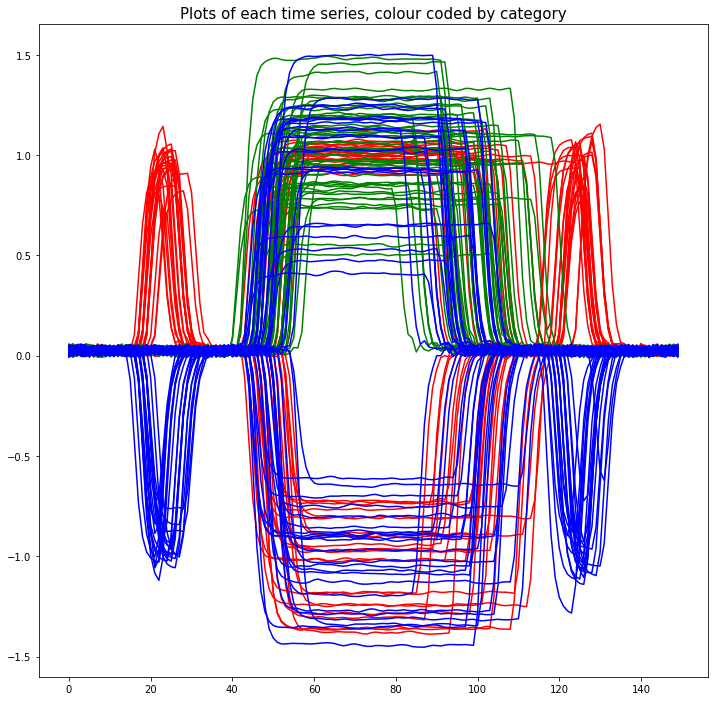

In [11]:
x_axis = [x for x in range(umd.shape[1])]
y = np.asarray(X_vals)
plt.figure(figsize=(12,12))
for i in range(len(y)):
    colour = 'red' if y_vals[i] == 1.0 else ('green' if y_vals[i] == 2.0 else 'blue')
    plt.plot(x_axis, X_vals[i], color=colour)
plt.title("Plots of each time series, colour coded by category", fontsize=15)
plt.show()

As the above is quite busy I will now plot each category separately

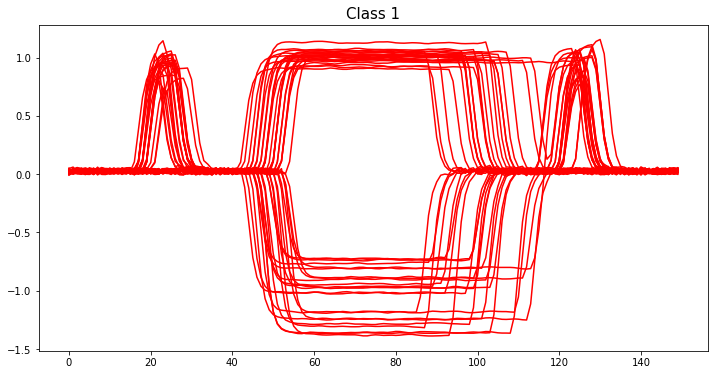

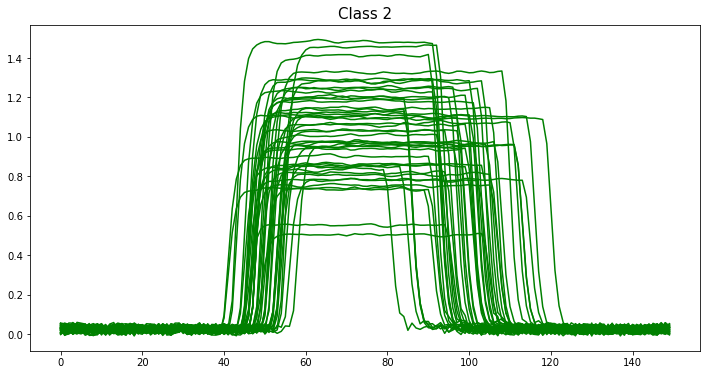

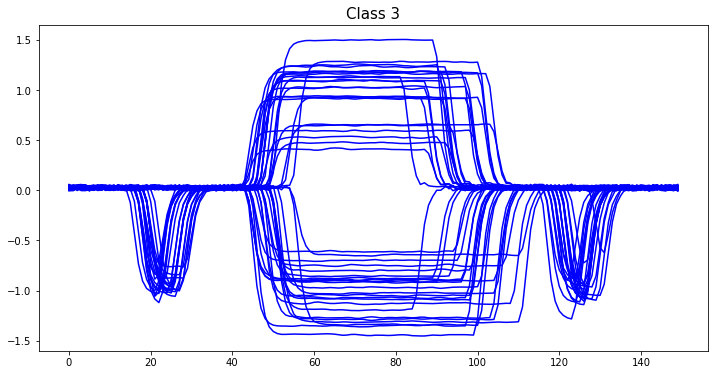

In [12]:
x_axis = [x for x in range(umd.shape[1])]
plt.figure(figsize=(12,6))
for i in range(len(y)):
    if y_vals[i] == 1.0:
        plt.plot(x_axis, X_vals[i], color="red")
plt.title("Class 1", fontsize=15)
plt.show()

plt.figure(figsize=(12,6))
for i in range(len(y)):
    if y_vals[i] == 2.0:
        plt.plot(x_axis, X_vals[i], color="green")
plt.title("Class 2", fontsize=15)
plt.show()

plt.figure(figsize=(12,6))
for i in range(len(y)):
    if y_vals[i] == 3.0:
        plt.plot(x_axis, X_vals[i], color="blue")
plt.title("Class 3", fontsize=15)
plt.show()

We can clearly see from the above that:

- Class 1 is characterised by 2 up bells, one at the beginning and one at the end, and is mostly positive
- Class 2 is characterised by 1 up bell in the middle and is positive
- Class 3 is characterised by 2 down bells, one at the beginning and one at the end, and is mostly negative

Now I will test the classification methods. I will split the dataset into training and test subsets, using sklearns train_test_split method. By default this randomly shuffles the dataset first, and will help ensure proportional representation of each category in both the training and test subsets.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_vals, y_vals, test_size=0.33, random_state=42)

In [14]:
correct_guesses_custom_1nn = assess(X_train, X_test, y_train, y_test)
print(str(round((correct_guesses_custom_1nn/len(X_test)*100),2))+"% correctly predicted")

85.42% correctly predicted


With c. 85% prediction accuracy this proves to be a reasonably good predictor. It would stand to reason of course that using a window size greater than 0 (so that we don't just have 1:1 matching) would increased the predictive accuracy given that from the plots above we can see that the distribution is far from uniform in time series from the same category.

### 1.3 Comparing against the performance of a 1-NN Euclidean Classifier

In [15]:
euclidean_1nn = KNeighborsClassifier(n_neighbors=1, metric='euclidean') 

In [16]:
euclidean_1nn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=1)

In [17]:
counter = 0
for i in range(len(X_test)):
    actual = y_test[i]
    predictedEuclidean = euclidean_1nn.predict([X_test[i]])[0]
    predictedDTW = predict(X_train, X_test[i], y_train)
    if predictedEuclidean != predictedDTW:
        print("Actual:", actual, "Euclidean Prediction:", predictedEuclidean, "DTW Prediction:", predictedDTW)
    if actual == predictedEuclidean:
        counter += 1
print("\n"+str(round((counter/len(X_test)*100),2))+"% correctly predicted by the Euclidean classifier")

Actual: 2.0 Euclidean Prediction: 2.0 DTW Prediction: 1.0
Actual: 3.0 Euclidean Prediction: 3.0 DTW Prediction: 2.0
Actual: 3.0 Euclidean Prediction: 1.0 DTW Prediction: 3.0
Actual: 3.0 Euclidean Prediction: 1.0 DTW Prediction: 3.0
Actual: 2.0 Euclidean Prediction: 1.0 DTW Prediction: 2.0
Actual: 3.0 Euclidean Prediction: 3.0 DTW Prediction: 2.0

85.42% correctly predicted by the Euclidean classifier


It is interesting to note that the accuracy for both classifiers in totality is the exact same, however of course as indicated by the above logging, this is not arrived at in the same way, and both methods predicted different values for some inputs. Indeed, using different train/test splits sometimes the Euclidean performed better and vice versa. (I did not implement cross validation as I believe printing the differences between method above achieves the same goal). There are 2 main points I want to draw out:

- Intuitively I would have expected that with a window size of 0 the DTW method would act in the same way, and indeed from the literature Euclidean is described as a special case of DTW with a window size of 0. One-to-one matching is taking place in both metrics in this instance, and the DTW is taking the absolute difference, versus the euclidean which takes the square root of the square of the differences. It is therefore surprising that they are not the exact same. I first considered that perhaps they were differening on occasions where there was more than 1 match for the minimum. However, I added a check in my above predict function which was never met. While I was unable to determine the exact cause, I would suspect some optimisation in the KNeighborsClassifier is causing this marginal difference in output. In any case, the key takeaway is that they are largely the same.
- The benefits of using DTW are removed by setting the window size to 0. The power of DTW relies on not doing one-to-one, which is enforced by choosing a window size of 0. As the window size increases we should expect the accuracy to increase, which is intuitive particulatly from the charts above where the series follow loosely the same path, but differing by a few time steps.

### 1.4 Exploring Window Sizes

Obviously it would not be correct to find the best window size by using the specific train/test split from before - this would just tell us the best window size for that specific split. Instead, I will assess each row against all of the others, for each window. This is the "leave-one-out" approach described by [Dau et al. (2018)](http://www.cs.ucr.edu/~hdau001/learn_dtw_parameter/learn_w_paper_DAMI.pdf), for determining the optimal window size.

In [18]:
def find_window(window, X_vals, y_vals):
    window_scores = []
    for i in range(window+1):
        correct, attempts = 0, 0
        for j in range(len(X_vals)):
            target_row = X_vals[j]
            tempX_Vals = np.delete(X_vals, j, 0)
            tempY_Vals = np.delete(y_vals, j, 0)
            prediction = predict(tempX_Vals, target_row, tempY_Vals, window=i)
            if prediction == y_vals[j]:
                correct += 1
            attempts += 1
        window_scores.append(correct/attempts)
        print("Window size:", i, "\nAccuracy:", round(correct/attempts, 4), "\n")
    return window_scores

<b>N.B.:</b> The below cell will take quite a bit of time to run

In [19]:
window_scores = find_window(10, X_vals, y_vals)

Window size: 0 
Accuracy: 0.8681 

Window size: 1 
Accuracy: 0.9097 

Window size: 2 
Accuracy: 0.9236 

Window size: 3 
Accuracy: 0.9236 

Window size: 4 
Accuracy: 0.9722 

Window size: 5 
Accuracy: 0.9722 

Window size: 6 
Accuracy: 0.9722 

Window size: 7 
Accuracy: 0.9653 

Window size: 8 
Accuracy: 0.9653 

Window size: 9 
Accuracy: 0.9653 

Window size: 10 
Accuracy: 0.9653 



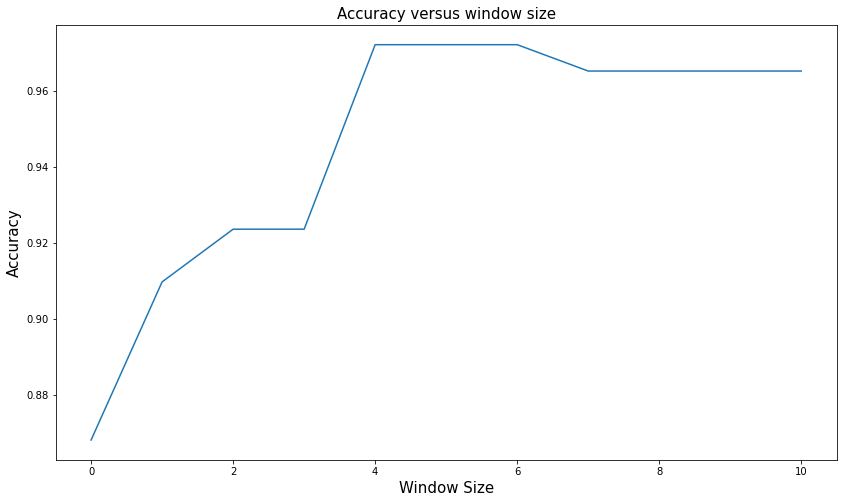

In [20]:
x_axis = [x for x in range(len(window_scores))]
plt.figure(figsize=(14,8))
plt.plot(x_axis, window_scores)
plt.xlabel("Window Size", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.title("Accuracy versus window size", fontsize=15)
plt.show()

Based on the above it is clear that the optimal window size is 4, and indeed once it reaches a window size of 7 it actually decreases to a slight extent. However, this is quite minimal, although intuitively it does make sense that increasing the window significantly could reduce accuracy as the matching has a greater chance of mistakenly matching to an inappropriate index as bending increases.

## Task 2

## 2.1 Adapting the DTW method to include in an sk-learn classifier

In order to convert the dtw method to a distance metric usable by sklearn, it is necessary to add an optional \*\*kwargs field to the method signature. This also adds the option of using the `metric_params` field, using which I can pass a dictionary of options, such as the window size.

In [21]:
# the method signature required for a custom distance function is to have an optional field (i.e. **kwargs)
# this allows 'metric_params' to be passed in with the desired window size
# using this I will pass in the window size
def adapted_dtw(s, t, **kwargs):
    n, m = len(s), len(t)
    if "window" in kwargs:
        w = np.max([kwargs["window"], abs(n-m)]) # warping cannot be less than the difference in lengths. 
    else:
        w = np.max([1, abs(n-m)]) # warping cannot be less than the difference in lengths. 
    dtw_matrix = np.zeros((n+1, m+1))
    
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            dtw_matrix[i, j] = 0
    
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix[-1,-1]

## 2.2 Verifying KNN performance using custom distance metric

To check if the KNeighborsClassifier uses the custom `adapted_dtw` distance function, I will pass it this metric function, and also set the window size to be 0 (although this would be 0 if I omitted this field in any case).

In [22]:
dtw_knn = KNeighborsClassifier(n_neighbors=1, metric=adapted_dtw, metric_params={'window':0}) 

In [23]:
dtw_knn.fit(X_train, y_train)

KNeighborsClassifier(metric=<function adapted_dtw at 0x7fa6306a9940>,
                     metric_params={'window': 0}, n_neighbors=1)

In [24]:
counter = 0
for i in range(len(X_test)):
    actual = y_test[i]
    predicted = dtw_knn.predict([X_test[i]])[0]
    if actual == predicted:
        counter += 1
print("\n"+str(round((counter/len(X_test)*100),2))+"% correctly predicted using the custom DTW metric in the KNeighborsClassifier.")
print(str(round((correct_guesses_custom_1nn/len(X_test)*100),2))+"% correctly predicted using my implementation of a 1-NN classifier.")
if counter == correct_guesses_custom_1nn:
    print("Results are consistent")


85.42% correctly predicted using the custom DTW metric in the KNeighborsClassifier.
85.42% correctly predicted using my implementation of a 1-NN classifier.
Results are consistent


## 2.3 Comparing classifier against KNN Euclidean

For the final task, I will use the optimal window size found in Task 1 (i.e. 4) for DTW, but as I am measuring performance against KNN euclidean I will also check a number of different neighbour sizes for both. In addition, I am also conducting cross fold validation manually. Below I set a list of seeds which will be iterated through for each number of neighbours and used to set the random_state in the `train_test_split` method which is run each time. Despite being confident that my original split led to representative samples in both the training and test given that there are only 3 categories and the rows are shuffled by default, this adds to the confidence I can have in my results.

<b>N.B.:</b> The below cell will take quite a bit of time to run

In [25]:
# set a number of neighbours that will be iterated over
neighbours = 10
# set a list of seeds that will be inputted into the train_test_split method as random states
seeds = [6, 13, 42]
# loop over the number of neighbours
for i in range(1, neighbours + 1):
    # initialise table to present results
    table = PrettyTable(["Fold", "KNN Euclidean", "KNN DTW"])
    
    # initialise lists to store the results of each fold
    dtw_folds = []
    euclidean_folds = []
    
    # initialise the classifier functions with the current number of neighbours
    dtw_knn = KNeighborsClassifier(n_neighbors=i, metric=adapted_dtw, metric_params={'window':4})
    euclidean_knn = KNeighborsClassifier(n_neighbors=i, metric='euclidean')
    
    # loop over the seeds
    for seed in seeds:
        # set the training and testing data based on the current seed
        X_train, X_test, y_train, y_test = train_test_split(X_vals, y_vals, test_size=0.33, random_state=seed)

        # fit models based on current train/test split
        dtw_knn.fit(X_train, y_train)
        euclidean_knn.fit(X_train, y_train)

        # initialise counters 
        counterDTW = 0
        counterEuclidean = 0

        # loop over the test values
        for j in range(len(X_test)):
            # get the actual value of y as well as the predictions from both classifiers
            actual = y_test[j]
            predictedDTW = dtw_knn.predict([X_test[j]])[0]
            predictedEuclidean = euclidean_knn.predict([X_test[j]])[0]

            # test if both of the predictions are correct 
            if actual == predictedDTW:
                counterDTW += 1
            if actual == predictedEuclidean:
                counterEuclidean += 1

        # add the results to the lists for folds
        dtw_folds.append(round(counterDTW/len(X_test)*100,2))
        euclidean_folds.append(round(counterEuclidean/len(X_test)*100,2))
    
    # once complete for all folds, print the results
    print("Number of neighbours:", i)
    for k in range(len(euclidean_folds)):
        table.add_row([k+1, str(euclidean_folds[k])+"%", str(dtw_folds[k])+"%"])
        # add line between each row
        table.hrules = 1
    
    # add the averages
    table.add_row(["Average", str(round(sum(euclidean_folds)/len(euclidean_folds),2))+"%", str(round(sum(dtw_folds)/len(dtw_folds),2))+"%"])    
    print(table)
    print("")

Number of neighbours: 1
+---------+---------------+---------+
|   Fold  | KNN Euclidean | KNN DTW |
+---------+---------------+---------+
|    1    |     85.42%    |  89.58% |
+---------+---------------+---------+
|    2    |     91.67%    |  91.67% |
+---------+---------------+---------+
|    3    |     85.42%    |  95.83% |
+---------+---------------+---------+
| Average |     87.5%     |  92.36% |
+---------+---------------+---------+

Number of neighbours: 2
+---------+---------------+---------+
|   Fold  | KNN Euclidean | KNN DTW |
+---------+---------------+---------+
|    1    |     87.5%     |  87.5%  |
+---------+---------------+---------+
|    2    |     83.33%    |  85.42% |
+---------+---------------+---------+
|    3    |     83.33%    |  87.5%  |
+---------+---------------+---------+
| Average |     84.72%    |  86.81% |
+---------+---------------+---------+

Number of neighbours: 3
+---------+---------------+---------+
|   Fold  | KNN Euclidean | KNN DTW |
+---------+---

As mentioned, above I have conducted KNN classification using both the KNN Euclidean classifier, as well as the KNN classifier implemented using the customised DTW method. The key takeaway from the above exploration in my opinion is the benefit of using correct distance metrics when conducting KNN classification. At first glance this was a problem that seemed like it may have been solvable using a naive euclidean distance metric, and while that still produced fairly accurate predictions, it is clear that using the DTW distance metric provides better classification predictions on average when the number of neighbours is small. As the number of neighbours increases it seems as though the accuracy decreases for both classifiers, which is unsurprising as when the number of neighbours is too large it is more likely to pick the average - this is especially true in the context of our series' only having 151 entries each, and so increasing the neighbours to 10, for example, is a large percentage of the length and increases the chances of the model perceiving a row as a member of an incorrect class. Therefore, I would not view the fact that the predictions were better for the euclidean distance when the number of neighbours was set to 8 neighbours as indicative of anything other than the number of neighbours being too high.

A further future area of exploration would be to identify the best DTW window size not just for when the number of neighbours was 1. Perhaps this would improve the accuracy further, although it is unlikely to be much better than having 1 neighbour given this is already so high (and this is why I did not conduct this analysis). It would also be interesting to explore using rows/time series of different sizes, as this is an area where the power of the DTW distance metric would really stand out versus euclidean.